# Definición del problema a resolver
• ¿Cuál es el problema?

• Acción que buscamos hacer para solucionar el problema

• ¿Cuáles son las variables disponibles?

• ¿En qué momento se va a implantar el modelo? ¿Qué variables hay disponibles en
el momento de llamada al modelo?

• ¿Cómo se va a validar el modelo?


Aquí hay que redactar una introducción explicando el caso y toda la parafernalia...

# Exploración general / inicial
• Dimensiones de la tabla y variables

• Analizar si las variables estarán disponibles en el momento de la llamada al modelo
(sino se estaría introduciendo información a futuro en el modelo)

• Exploración de la variable objetivo

• Rápido análisis de valores nulos

• Se explora el número de variables numéricas y categóricas y se decide qué proceso
realizar para tratarlas

• Transformaciones iniciales de algunas variables: formato de fechas, eliminar
espacios de una variable string, etc

• Analizar la variable objetivo: aislándola de las demás variables (quizás, a pesar de
no tener en cuenta las variables tenemos que sacar un 80% de accuracy.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/NCDB_1999_to_2014.csv")

C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (1,2,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print("El dataset está compuesto por", len(df.index), "filas")
print("El dataset tiene", len(df.columns), "columnas / variables")
df.head(5)


El dataset está compuesto por 5860405 filas
El dataset tiene 22 columnas / variables


,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


In [4]:
# Cambio de nombre de las variables
new_names = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state", "vehicle_id", "vehicle_type", "vehicle_year", "passenger_id", "passenger_sex",
"passenger_age", "passenger_role", "passenger_fatality", "passenger_safety", "passenger_type"]

print(len(new_names) == len(df.columns))

df.columns = new_names

True


In [5]:
df.dtypes

year                   int64
month                 object
weekday               object
hour                  object
fatality               int64
vehicles_involved     object
crash_type            object
crash_place           object
crash_weather         object
surface_state         object
road_slope            object
traffic_state         object
vehicle_id            object
vehicle_type          object
vehicle_year          object
passenger_id          object
passenger_sex         object
passenger_age         object
passenger_role        object
passenger_fatality    object
passenger_safety      object
passenger_type        object
dtype: object

In [6]:
# Cambio de la variable vehicle_year a años de antigüedad (la he metido en otra columna por el momento)
df['vehicle_age'] = df.year - pd.to_numeric(df.vehicle_year, errors= "coerce")

In [7]:
# Limpieza de valores U, UU y UUUU (son NA "puros" según el diccionario)
df = df.replace({"U": np.nan, "UU": np.nan, "UUUU": np.nan})

In [8]:
new_columns = list(df.columns[0:4]) + list(df.columns[5:]) + list(df.columns[4:5])

df = df[new_columns]

In [9]:
# Columna MONTH
print(df["month"].unique())
df["month"] = np.int8(df["month"].replace({"01": 1, "02": 2, "11": 11, "12" : 12}))

[1 2 3 4 5 6 7 8 9 10 11 12 '12' nan '01' '02' '11']


In [10]:
df = df[df["month"] != 0]

In [11]:
df["month"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int8)

In [12]:
month_analysis = df.groupby(["month", "fatality"]).size()

for i in range(1, 1+ np.int8(len(month_analysis)/2)):
    print("El porcentaje de fatalities/accidente para el mes",
    i ,"es del",round(month_analysis[i][1]/month_analysis[i].sum()*100, 3), "%")

El porcentaje de fatalities/accidente para el mes 1 es del 1.506 %
El porcentaje de fatalities/accidente para el mes 2 es del 1.501 %
El porcentaje de fatalities/accidente para el mes 3 es del 1.56 %
El porcentaje de fatalities/accidente para el mes 4 es del 1.576 %
El porcentaje de fatalities/accidente para el mes 5 es del 1.641 %
El porcentaje de fatalities/accidente para el mes 6 es del 1.658 %
El porcentaje de fatalities/accidente para el mes 7 es del 1.91 %
El porcentaje de fatalities/accidente para el mes 8 es del 1.903 %
El porcentaje de fatalities/accidente para el mes 9 es del 1.771 %
El porcentaje de fatalities/accidente para el mes 10 es del 1.71 %
El porcentaje de fatalities/accidente para el mes 11 es del 1.66 %
El porcentaje de fatalities/accidente para el mes 12 es del 1.688 %


### Dividiremos la variable month en cuatro valores distintos, representando los distintos trimestres del año (Q1-4).
#### La razón para esto es la existencia de un patrón estacional en el que los distintos trimestres (o estaciones del año) tienen valores similares a la hora de relacionarse con la variable objetivo $fatality$

In [13]:
df["month"] = df["month"].replace({1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4})

## Columna Weekday

In [14]:
print(df["weekday"].unique())
df["weekday"] = np.int8(df["weekday"].replace({"7": 7, "1": 1, "2": 2, "3" : 3, "4":4, "5":5, "6":6}))
print(df["weekday"].unique())

[1 2 3 4 5 6 7 '7' nan '1' '2' '3' '4' '5' '6']
[1 2 3 4 5 6 7 0]


Las filas con NA en weekday (valor 0 para el día de la semana) son un número mínimo en comparación con el tamaño del data-set así que nos deshacemos de ellas

In [15]:
# Nos deshacemos de esas filas
df = df[df["weekday"] != 0]

In [16]:
weekday_analysis = df.groupby(["weekday", "fatality"]).size()

for i in range(1, 1+ np.int8(len(weekday_analysis)/2)):
    print("El porcentaje de fatalities/accidente para el día de la semana",
    i ,"es del",round(weekday_analysis[i][1]/weekday_analysis[i].sum()*100, 3), "%")

El porcentaje de fatalities/accidente para el día de la semana 1 es del 1.543 %
El porcentaje de fatalities/accidente para el día de la semana 2 es del 1.428 %
El porcentaje de fatalities/accidente para el día de la semana 3 es del 1.422 %
El porcentaje de fatalities/accidente para el día de la semana 4 es del 1.545 %
El porcentaje de fatalities/accidente para el día de la semana 5 es del 1.655 %
El porcentaje de fatalities/accidente para el día de la semana 6 es del 2.059 %
El porcentaje de fatalities/accidente para el día de la semana 7 es del 2.187 %


## Columna $hour$
### Opción 1: https://towardsdatascience.com/how-to-handle-cyclical-data-in-machine-learning-3e0336f7f97c
### Opción 2: Identificar distintos "tramos" de similar influencia en $fatalities$ y luego hotencodearlo. Habría que hacerlo por tramos para reducir, ya que 24 variables para la hora quizás sean demasiadas

In [17]:
df = df[df["hour"].notnull()]
df["hour"] = df["hour"].astype("int8")

El porcentaje de fatalities/accidente para la hora 0 es del 3.357 %
El porcentaje de fatalities/accidente para la hora 1 es del 4.059 %
El porcentaje de fatalities/accidente para la hora 2 es del 4.092 %
El porcentaje de fatalities/accidente para la hora 3 es del 4.08 %
El porcentaje de fatalities/accidente para la hora 4 es del 4.32 %
El porcentaje de fatalities/accidente para la hora 5 es del 4.228 %
El porcentaje de fatalities/accidente para la hora 6 es del 2.445 %
El porcentaje de fatalities/accidente para la hora 7 es del 1.615 %
El porcentaje de fatalities/accidente para la hora 8 es del 1.18 %
El porcentaje de fatalities/accidente para la hora 9 es del 1.576 %
El porcentaje de fatalities/accidente para la hora 10 es del 1.581 %
El porcentaje de fatalities/accidente para la hora 11 es del 1.392 %
El porcentaje de fatalities/accidente para la hora 12 es del 1.296 %
El porcentaje de fatalities/accidente para la hora 13 es del 1.305 %
El porcentaje de fatalities/accidente para la h

<AxesSubplot:>

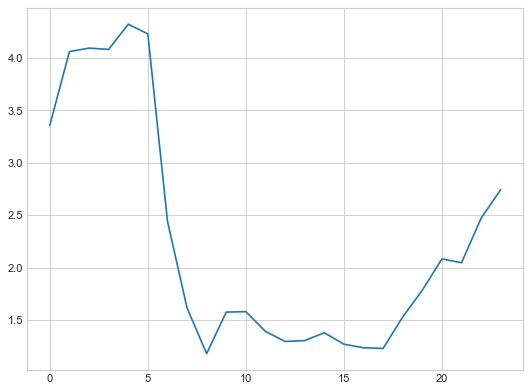

In [18]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8,6), dpi=80)


hour_analysis = df.groupby(["hour", "fatality"]).size()
hour_values = list()

for i in range(0, int(len(hour_analysis)/2)):
    print("El porcentaje de fatalities/accidente para la hora",
    i ,"es del",round(hour_analysis[i][1]/hour_analysis[i].sum()*100, 3), "%")
    hour_values.append(hour_analysis[i][1]/hour_analysis[i].sum()*100)

hour_values = pd.DataFrame(hour_values)
hour_values.T.iloc[0].plot()

## Variable objetivo

In [19]:
# Recodeado de la variable objetivo
# Antes: 1-fatality 2-no fatality
# Después: 1-fatality 2-no fatality
df['fatality'] = df['fatality'].replace({2:0})

In [20]:
# He pensado en unificar las columnas de fecha pero he observado que la proporción de muertes / heridos es bastante diferente según el día de la semana (e imagino que también por la hora)

print(df.fatality.value_counts() / len(df.index) * 100)

df.loc[df["weekday"] == 6].fatality.value_counts() / len(df.loc[df["weekday"] == 6].index) * 100

0    98.318246
1     1.681754
Name: fatality, dtype: float64


0    97.940931
1     2.059069
Name: fatality, dtype: float64

In [21]:
# analizar nulos
df_dtypes = pd.merge(df.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')

df_dtypes.sort_values(['missing_value', 'feature_type'])

,index,missing_value,feature_type
1,hour,0,int8
4,weekday,0,int8
0,year,0,int64
2,fatality,0,int64
3,month,0,int64
5,passenger_id,16,object
6,vehicles_involved,343,object
7,vehicle_id,432,object
8,vehicle_type,29262,object
9,passenger_role,57342,object


Apenas tenemos valores NA, o eso parece... Sin embargo, el dataset no utiliza espacios vacíos para representar los valores desconocidos si no caracteres como X o XX. El diccionario refleja esto.